# Latent Dirichlet Allocation and Genomic Ancestry

Genomic data offers invaluable insights into human and animal migration patterns and ancestry, making it a powerful tool for reconstructing history of the world populations. In this project we will analyse genotype data that has been collected from individuals across multiple continents using two latent variable technigue: Principal Component Analysis (PCA) and Latent Dirichlet Allocation (LDA). We will see how both methods can inform on geographical location and ancestry of an individual. 

We will perform analysis on human genotype data from the [1000G project](https://www.internationalgenome.org/). There are multiple dataset available on this ressource, and data preparation can take a large amount of time. We will thus start with a table of selected genotypes provided on the [ancestry_viz github page](https://github.com/hagax8/ancestry_viz). The working tables are provided together with the notebook and were obtained by considering a set of 1976 individuals that were analysed in the [1000G project landmark article](https://www.nature.com/articles/nature15393) and filtering sequence variations according to their diversity based on population genetics models (more details are available on the [corresponding ancestry_viz wiki](https://github.com/hagax8/uGTM/wiki/Appendix:-Generate-ancestry-files)). 

The project will be divided into different tasks:
1. Data loading and visualization of the properties of the variations
2. Application of PCA to the genotype matrix 
3. Presentation of the LDA model and application to 1000G data

## 0. What are SNPS and how can they be used for diagnostic?

SNPs (Single Nucleotide Polymorphisms) are variations at specific DNA positions where a single nucleotide differs among individuals, serving as important genetic markers for researching human diversity and disease associations.

Some SNPs that directly influence a phenotype are known to correlate with geographical ancestry. A famous example is the difference in proportion of the SNPs related to lactose intolerance accross different populations. You can have a look at real data on this subject with this [short tutorial](https://genome.ucsc.edu/training/education/lactase.html). However those cases are rather more the exception than the norm. If one part of genome analysis are concerned the understanding of how a given combination of SNPs can influence characteristics of an individual, a more general question is only concerned how SNP patterns change across populations.

In the following we will be only looking at the changes in SNPs proportion accross different individuals and see how one can use this information to predict the population of an individual. 



## 1. Data loading and visualization

We will be using data from the one thousand genome (1000G) project where individuals from multiple geographic location have been genotyped using a high density genotyping chip. The table is further processed to include only SNPs occuring in a sufficient proportion (more than 2% of the population) and where the proportion of heterozygous alleles follows [Hardy-Weinberg principle](https://en.wikipedia.org/wiki/Hardy%E2%80%93Weinberg_principle) on each chromosome. 

Because the table has been processed we will unfortunately not be able to check if any famous mutation (like the one we just mentionned above about lactose intolerance) is varying in proportion across populations.

Let's proceed with a first short step of data cleaning, followed by an exploratory data analysis on the whole dataset.

In [62]:
!uv pip install seaborn

Using Python 3.13.9 environment at: c:\Users\Lennard\UNI\courses\AppliedPML\projects\ma-cs-apml\.venv
Audited 1 package in 479ms


In [1]:
## Preparing the modules that will be needed in the following
##
import numpy as np
from numpy import ndarray
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA, LatentDirichletAllocation
import matplotlib.pyplot as plt



Note that the matrix of SNPs provided with the notebook is compressed with xz, you can also directly download it 
at [this address](http://lovingscience.com/ancestries/downloads/recoded_1000G.noadmixed.mat)

In [2]:
## We start with populations that are not admixed 
genotypes = pd.read_csv("./recoded_1000G.noadmixed.mat.xz", delimiter = ",",
                        header = None)

print("Size of the genotype matrix:", genotypes.shape)

## The annotation of the genotypes individuals
genotypes_annotation = pd.read_csv("./noAdmixed_1000G_id_labels.csv")


print(genotypes.shape)
print(genotypes_annotation.columns)


Size of the genotype matrix: (1976, 39182)
(1976, 39182)
Index(['id', '1000G population code', 'population',
       '1000G superpopulation code'],
      dtype='object')


In [3]:
# The annotations are in the same order as the genotypes, 
# it's possible to concatenate them when needed

genotype_w_annotation = pd.concat([genotypes, 
                                    genotypes_annotation],
                                    axis = 1)

genotype_w_annotation 

,0,1,2,3,4,5,6,7,8,9,...,39176,39177,39178,39179,39180,39181,id,1000G population code,population,1000G superpopulation code
0,0,0,0,0,1,1,0,0,0,0,...,1,1,0,1,2,1,HG02461,GWD,Gambian in Western Divisions in the Gambia,AFR
1,0,0,0,2,0,2,0,0,0,0,...,1,1,2,2,1,0,HG02462,GWD,Gambian in Western Divisions in the Gambia,AFR
2,0,1,0,2,0,1,0,0,1,0,...,0,1,1,1,1,0,HG02464,GWD,Gambian in Western Divisions in the Gambia,AFR
3,0,2,1,0,0,0,0,1,1,1,...,1,0,0,1,1,0,HG02465,GWD,Gambian in Western Divisions in the Gambia,AFR
4,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,2,HG02561,GWD,Gambian in Western Divisions in the Gambia,AFR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,0,0,1,0,2,2,0,1,0,0,...,1,0,0,2,0,0,HG04186,BEB,Bengali from Bangladesh,SAS
1972,0,0,0,0,1,0,1,1,0,0,...,2,1,0,2,1,0,HG04188,BEB,Bengali from Bangladesh,SAS
1973,0,0,0,0,2,1,0,1,0,0,...,0,1,0,1,1,1,HG04189,BEB,Bengali from Bangladesh,SAS
1974,1,0,0,1,1,2,0,1,0,0,...,1,1,0,0,1,0,HG04194,BEB,Bengali from Bangladesh,SAS


### Data cleaning

The data consists of 1976 individuals (rows) and 39,182 SNPs (columns). Recall that human genomes are diploid (two copies of each chromosome) so there are always two alleles for one position. Thus each cell has 3 possible values:
- 0: both allele are the same as the one on the reference genome (`REF`)
- 1: both alleles are the alternative allele (`ALT`)
- 2: We have an heterozygous allele with one ref and one alt  (`HTZ`)

The annotation consists in 4 columns:
- `id`: the individual ID
- `1000G population code`: the 1000G population code (total: 20)
- `population`: The population in a readable form
- `1000G superpopulation code`: a superpopulation code (total: 5)
  - `AFR`: African
  - `AMR`: Admixed American
  - `EAS`: East Asian
  - `EUR`: European
  - `SAS`: South Asian

#### **Questions:**
- First plot an histogram of the proportion of `ALT` and `HTZ` accross indiviuduals and depending on the superpopulation. 
  - Do we observe a difference in the proportion of heterozygous or alternative allele depending on the superpopulation. 
  - How would you explain this effect?
- Like for the regression project, we have to deal with missing data. We will be replacing them with the **median** values observed in for each column. 
  - Report the number of columns with missing data and their counts. 
  - Use the `fillna` method from pandas to replace the missing value by their median.


<Axes: xlabel='HTZ', ylabel='Count'>

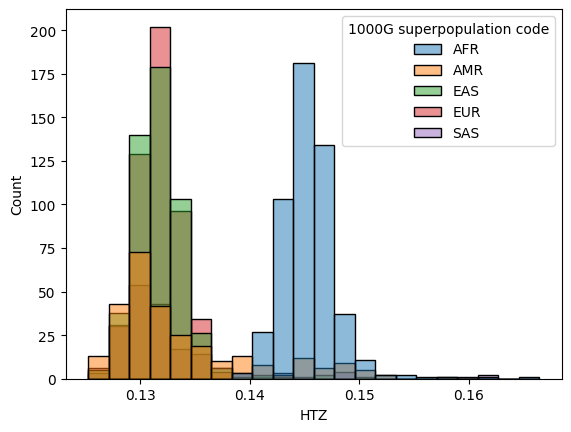

In [4]:

## Compute the proportion of alleles and impute the NAs

## You code here 

count = genotypes.shape[1]

prop_alt = (genotypes == 1).sum(axis=1) / count
prop_htz = (genotypes == 2).sum(axis=1) / count

geno_prop = pd.DataFrame({
    "ALT": prop_alt,
    "HTZ": prop_htz,
    "1000G superpopulation code": genotype_w_annotation["1000G superpopulation code"]})


### Plotting can be done with the seaborn function

sns.histplot(geno_prop, x= "HTZ", 
             hue = '1000G superpopulation code')


<Axes: xlabel='ALT', ylabel='Count'>

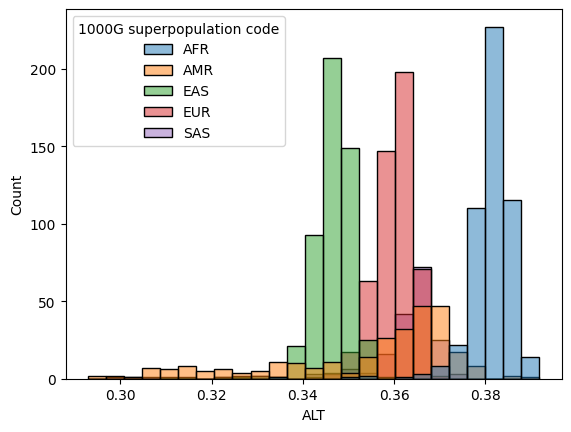

In [5]:
sns.histplot(geno_prop, x= "ALT", 
             hue = '1000G superpopulation code')

- Do we observe a difference in the proportion of heterozygous or alternative allele depending on the superpopulation. 
- How would you explain this effect?

Depending on the superpopulation, the proportion of alternative alleles differs clearly between EAS, EUR, and AFR, with varying intensities, while AMR and SAS are less distinct. For heterozygosity, most superpopulations show similar values, except AFR, which has a noticeably higher heterozygous proportion.

This effect can be explained by differences in genetic diversity among populations, especially the higher genetic diversity in African populations. 

In [6]:
columns_num = genotype_w_annotation.select_dtypes(include="number").columns

only_numbers = genotype_w_annotation[columns_num]

missing = only_numbers.isna().sum()

columns_missing = missing[missing > 0]

print(columns_missing.shape[0])
print(columns_missing)


242
105      16
290       1
762      12
953       8
1257     11
         ..
38599     6
38651    10
38739    11
38809     5
39109    14
Length: 242, dtype: int64


In [7]:
genotype_w_annotation[columns_num] = genotype_w_annotation[columns_num].fillna(
    genotype_w_annotation[columns_num].median()
)

In [8]:
genotype_w_annotation.isna().sum().sum()

np.int64(0)

## 2. Applying PCA to the 1000G data

In this task we will be applying PCA to the matrix of SNPs and see how the genotype is dispersed according to the geographical location of the subjects.

To perform the PCA, we will use the `sklearn` environnment. Before applying PCA, it is usually advised to scale it according to the mean and standard deviation (you can use the `sklearn.preprocessing.StandardScaler` method for that). You can then construct a `sklearn.decomposition.PCA` object and apply its `fit` method to obtain principal components and results.

### **Questions:**

- Fit a Principal Component Analysis on the data. Represent the proportion of the variance captured by the principal components as a function of the number of components. 
  - How many components are able to capture most of the linear effects in the data? 
  - What is the cumulative proportion of the variance then explained? 
  - Would you say that PCA is a good dimension reduction technique? 
- Plot the first principal components as pairplots, what do you observe in terms of separation of the superpopulations on the first components? 
- How would you interpret those two observations? 

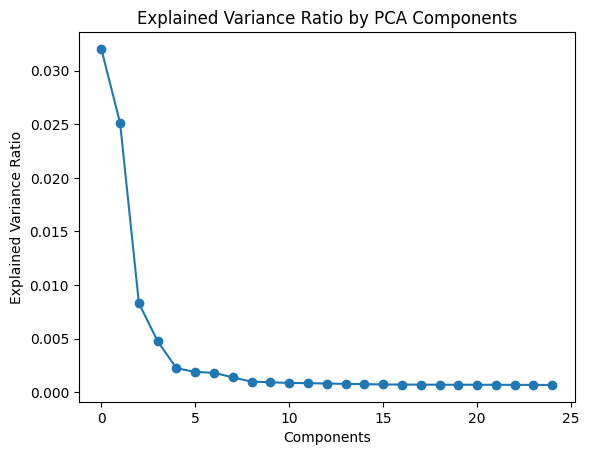

In [9]:

random_state = 42

scaler = preprocessing.StandardScaler()

X = genotype_w_annotation[columns_num]
Y = genotype_w_annotation["1000G superpopulation code"]

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=25, random_state=random_state)
pca.fit(X_scaled)

plt.figure()
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.xlabel("Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio by PCA Components")
plt.show()

### Your code here 

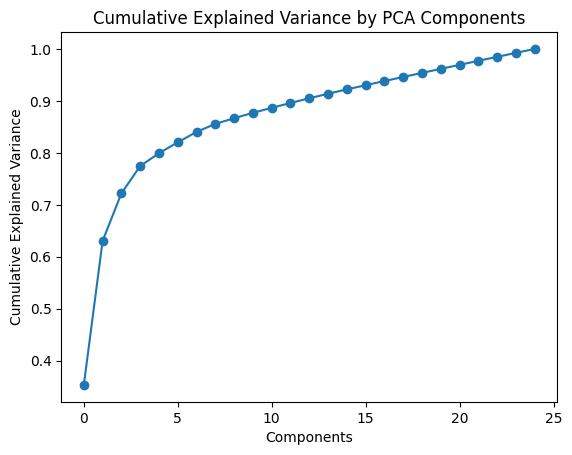

In [10]:
cum_variance = np.cumsum(pca.explained_variance_ratio_) / np.sum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cum_variance, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()

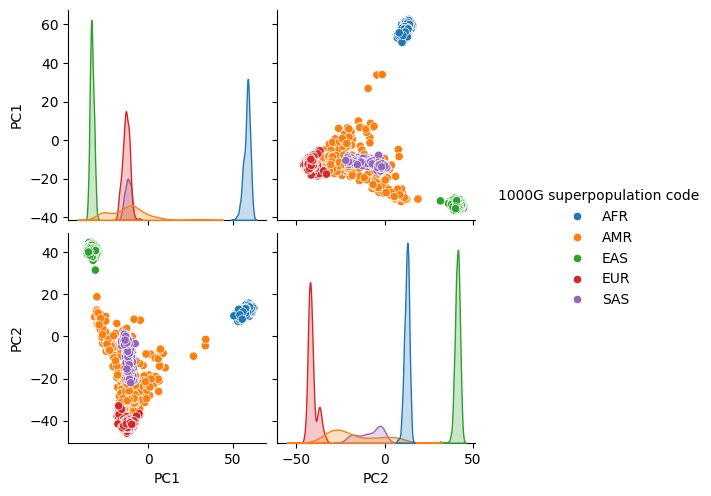

In [11]:
pca_2 = PCA(n_components=2, random_state=random_state)
X_pca_2 = pca_2.fit_transform(X_scaled)
pca_df_2 = pd.DataFrame(X_pca_2, columns=[f"PC{i+1}" for i in range(X_pca_2.shape[1])])
pca_df_2["1000G superpopulation code"] = Y

sns.pairplot(pca_df_2, hue="1000G superpopulation code")
plt.show()

The plots clearly show that most of the structure in the data is captured by the first 4 components, because the curve starts to flatten. With the 5 component nearly 85% of the total variance is explained. So the PCA is a suitable method for reducing the dimensions in the data table. Based on this we decided to use five components for further analysis.

In the first two components we can already see how the superpopulations separated, exspecially for EAS and AFR. However AMR overlaps EUR and SAS, as it is more widely spread. This indicates that the first component capture the main genetic differences between the superpopulations and reflect the underlying population structure.

In [12]:
n = 5

pca_n = PCA(n_components=n, random_state=random_state)
X_pca_n = pca_n.fit_transform(X_scaled)

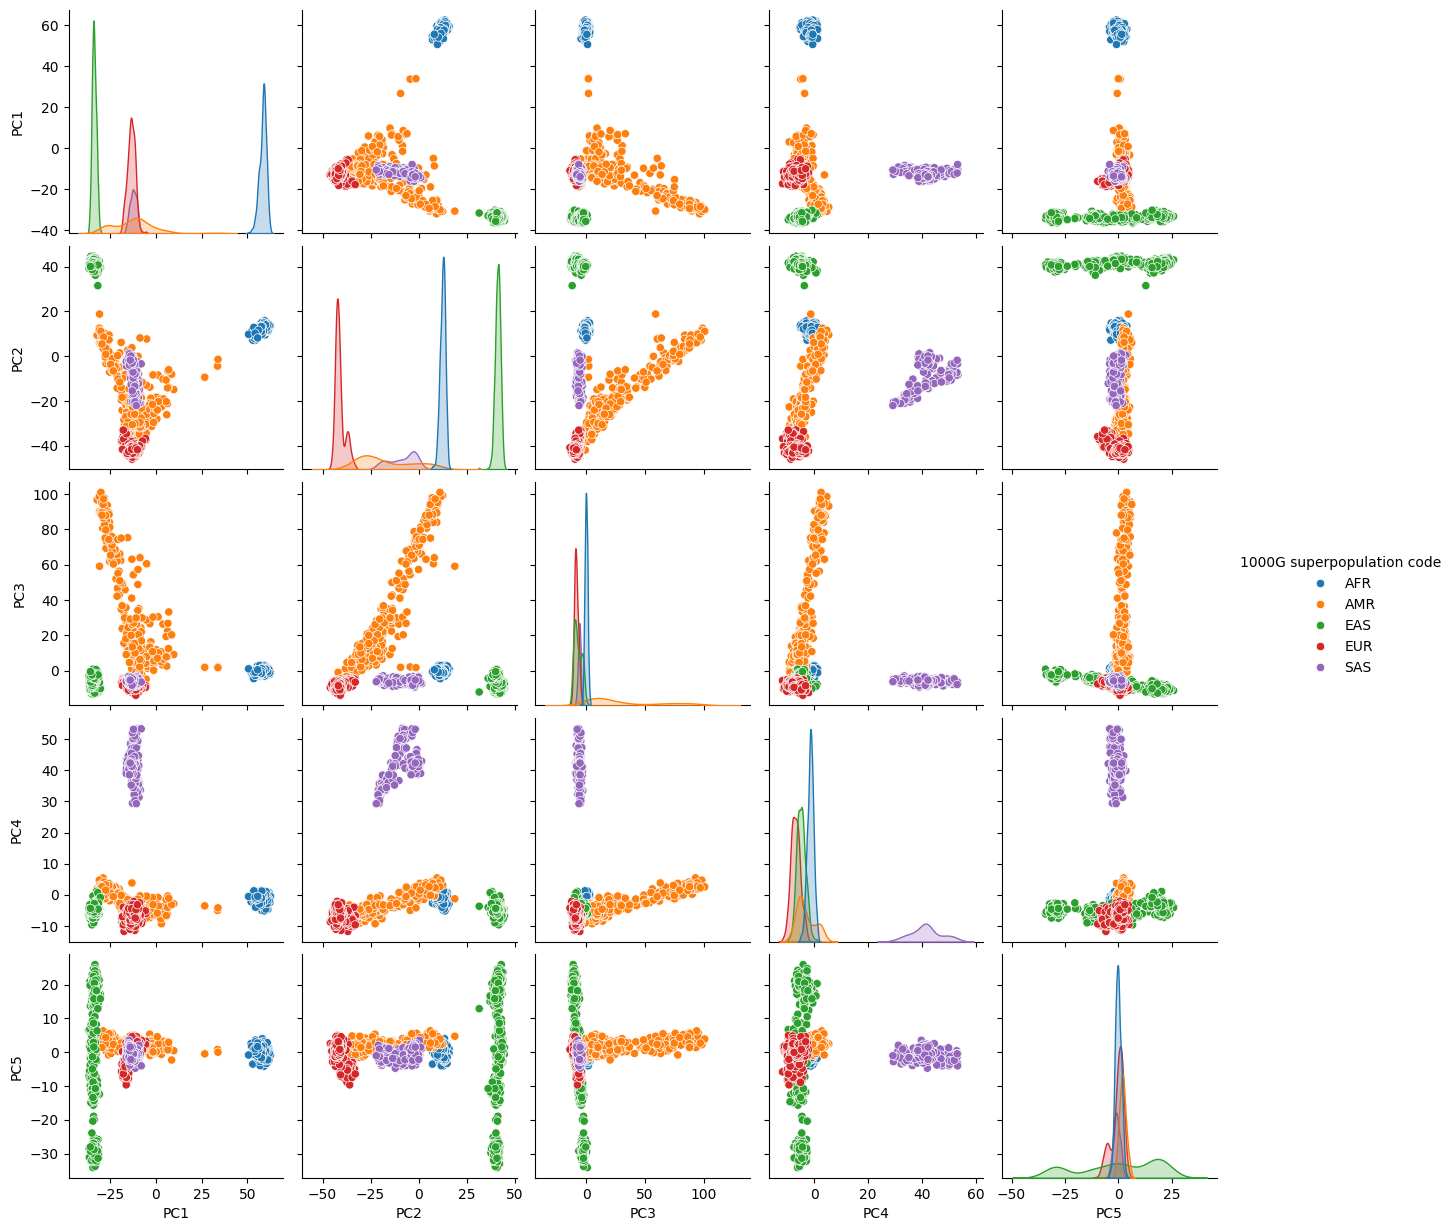

In [13]:
pca_df = pd.DataFrame(X_pca_n, columns=[f"PC{i+1}" for i in range(X_pca_n.shape[1])])
pca_df["1000G superpopulation code"] = Y

sns.pairplot(pca_df, hue="1000G superpopulation code")
plt.show()

### Using PCA for classification

We see that the PCA projection separates somehow the superpopulation already in the first principal components. We want to test to which accuracy the information of the genotype can be used to predict the superpopulation in a classification framework. We will simply compare a simple k-nearest neighbour classifier based on the euclidian distance of the genotypes, and a classifer using the first components of the PCA.

### **Questions:**
- Separate the dataset into a training and a testing set with a 80% / 20% ratio
- Compare the accuracy for the classification of the superpopulation based on a k-nearest neighbors classifier based on: 
  - the whole genotype vector for each individual
  - the projection of the genotype vector on the 5 first principal components. 


In [14]:
## Prepare train / test in a stratified manner
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, stratify=Y)

# n_folds = 2 
# folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

# folds.split

Accuracy: 0.9874


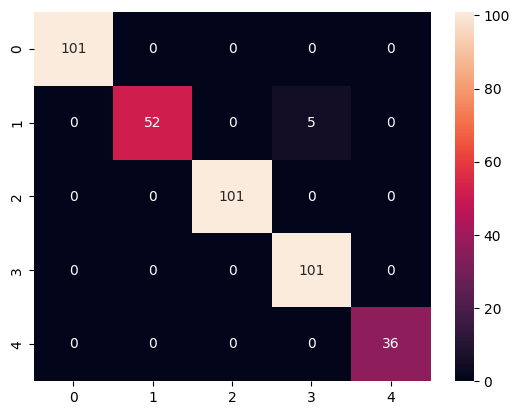

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()

In [16]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca_n, Y, test_size=0.2, random_state=random_state, stratify=Y)

Accuracy (PCA): 0.9975


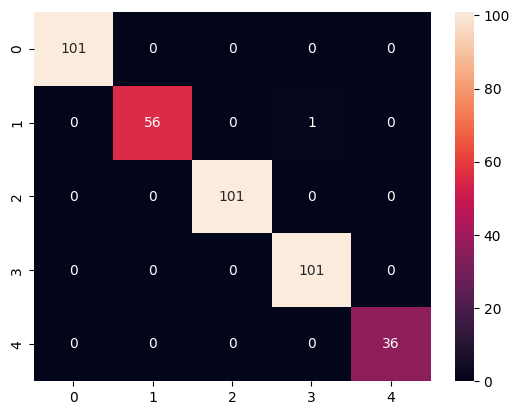

In [48]:
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, Y_train_pca)

Y_pred_pca = knn_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(Y_test_pca, Y_pred_pca)
print(f"Accuracy (PCA): {accuracy_pca:.4f}")
cm = confusion_matrix(Y_test_pca, Y_pred_pca)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()

The accuracy of the k-nearest neighbors classifiers are both quite good. However the PCA-knn-classififier has a nearly perfect accuracy. This indicates that the dimensions reduction improved the performance.

## 3. Applying Latent Dirichlet Allocation 


### Notations

We simply define as a reminder here the LDA model for document classification. We will be then using an `sklearn` method to estimate it on the 1000G project collection of genotypes. 

Let's remind the notations and the parameters of the model. The vocabulary is of size $V$, and we have $N$ documents of size $L_i$ each. 
We work with the $N\times V$ matrix $C$ or number of occurrence for each word in each document. 
Then the parameters of an LDA model with $K$ topics are:
$$
\begin{align*}
\Theta                   & = (\alpha, \gamma, \mathbf{B}, \pi, \mathbf{q})\\
\pi_i \mid \alpha        & \sim \text{Dir}(\alpha \bullet\mathbf{1}_K)\\
q_{i,l} \mid \pi_i          & \sim \text{Cat}(\pi_{i}[1], \ldots, \pi_i[K]) \\
\mathbf{b}_k \mid \gamma & \sim \text{Dir}(\gamma \bullet \mathbf{1}_K)\\
y_{i,l} \mid q_{i,l} = k, \mathbf{B} & \sim \text{Cat}(b_{k}[1], \ldots, b_{k}[V])
\end{align*}
$$

Note that the sufficient statistic (the only observation needed) to learn the model is the count matrix $C$, as was the case previously. To estimate words per topics probabilities $\mathbf{b}_k$ we only need to obtain an annotated 3D count matrix $N = n_{i,k,v}$ that counts the number of time word $v$ is assigned to topic $k$ in document $i$ (note that the position in the sequence doesn't play a role anymore). From there the point estimators can be obtained by marginalising:
$$
\begin{align*}
b_{k}[v] & = \frac{\sum_{i=1}^{N} n_{i,k, v}}{\sum_{i=i}^{N} \sum_{v=1}^{V} n_{i,k,v}}\\
\pi_i[k] & = \frac{\sum_{v=1}^{V} n_{i,k, v}} {\sum_{v=1}^{V}\sum_{k=1}^{K} n_{i,k,v}}
\end{align*}
$$



### Data encoding

We will now get back to our 1000G project genotypes and apply the LDA model to it. The main question we will need to address are:
- How many population should we use? 
- How to use the results in an easy way?

But first we need to adapt the genotype data to the topic model as we specified it. 

In this case, each  genotype position corresponds to a word $v$ and the ALT is occuring with a certain proportion $b_{k}[v]$ in the topic (*e.g.* population) $k$. 

We thus have to count in principle $2$ occurrences for an `ALT` allele and $1$ occurrence for a `HTZ` one.

We consider each SNP as being a different case, however if we have a 2 we should count the word as occurring twice, and thus we will be counting differently :
- Alternative alleles with a count of 1
- Heterozygous alleles with a count of 0.5

### Question 

Write a short function to reencode the matrix of all genotypes as a bag of words dataset that can  where each SNP is a word in the vocabulary and it's occurrence is given

In [18]:
def fill_missing(genotype_matrix):
    columns_num = genotype_matrix.select_dtypes(include="number").columns
    genotype_matrix[columns_num] = genotype_matrix[columns_num].fillna(
    genotype_matrix[columns_num].median()
    )
    return genotype_matrix

In [19]:
## You can work with a sparse matrix of the genotypes constructed with
## scipy, this way the code will run faster later
from scipy.sparse import csr_matrix

## The data matrix can be specified as a csr_matrix

def reencode_matrix(genotype_matrix) -> csr_matrix:
    genotype_matrix = fill_missing(genotype_matrix)
    genotype_matrix[genotype_matrix == 1] = 1.0
    genotype_matrix[genotype_matrix == 2] = 0.5
    return csr_matrix(genotype_matrix)

genotypes_for_lda = reencode_matrix(genotypes)


/var/folders/_3/nm_bc9fx7t55l0fvfvxm8bww0000gn/T/ipykernel_85848/2596981318.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  genotype_matrix[genotype_matrix == 2] = 0.5


### Applying the LDA model to the genotype data

We now apply the LDA model with a different number of topics and monitor how well the model fits the data, but using measures such as perplexity and likelihood to assess the fit of the model. 

### **Questions:**
- Run the LDA estimation for an increasing number of topics, starting with 3 topics. You can compute the approximate perplexity or the log-likelihood as a measure of model fit. An example object is defined below to help you specify some of the parameters.
- For a number of topics from 3 to 6, represent the proportion of each topic that was estimated for each individual. You can get inspiration from the figure 1 presented in [this publication](https://rosenberglab.stanford.edu/papers/popstruct.pdf).  
  - Does the LDA model recovers some of the geographical locations the genomes were sampled from? 
  - What other comments can you make about the data? 
  - Are all the populations with the same kind of topic composition? 
- The 1000G project also genotyped populations that are known to present higher level of admixture. Consider the LDA model with 6 topics estimated at the previous question and apply it to the matrix genotypes obtained from the population of mexican ancestry (matrix `recoded_1000G_MXL.mat.xz` that can be also downloaded [here](http://lovingscience.com/ancestries/downloads/recoded_1000G_MXL.mat)). What do you observe? 

*Note:* You can use the `transform` method from the `LatentDirichletAllocation` class to estimate topic proportions for each individual using the data matrix.

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
from time import time

## Example on how to specify the LDA model 
lda_5pop = LatentDirichletAllocation(
    n_components=5,
    max_iter=40, # 40 iteration should ensure convergence, but you can try lower values.
    learning_method="batch", ## 'online' method is recommended if the matrix doesn't fit in memory
    learning_offset=50.0, ##Used in the case of the online training
    random_state=42,
    n_jobs= 1 #change that if multiple cores are available
)

## Note that estimation can take up to 10 min per model.



In [ ]:
import os, json

OUT_FILE = "lda_model_results.json"
perplexities = {}
log_likelihoods = {}
topic_predictions = {}

if not os.path.exists(OUT_FILE):
    for n_topics in range(3,7):
        model = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=40,
            learning_method="batch",
            learning_offset=50.0,
            random_state=42,
            n_jobs=1,
            verbose=True
        )
        start_time = time()
        model.fit(genotypes_for_lda)
        end_time = time()
        perplexity = model.perplexity(genotypes_for_lda)
        log_likelihood = model.score(genotypes_for_lda)
        perplexities[n_topics] = perplexity
        log_likelihoods[n_topics] = log_likelihood
        topic_predictions[n_topics] = model.transform(genotypes_for_lda).tolist()
        print(f"LDA model with {n_topics} topics fitted in {end_time - start_time:.2f} seconds with perplexity {perplexity:.2f} and log-likelihood {log_likelihood:.2f}")
        with open(OUT_FILE, "w") as f:
            json.dump({
                "perplexies": perplexities,
                "log_likelihoods": log_likelihoods,
                "topic_predictions": topic_predictions
            }, f)
else:
    print(f"Results file {OUT_FILE} already exists. Skipping LDA model fitting.")

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

In [ ]:
if os.path.exists(OUT_FILE):
    with open(OUT_FILE, "r") as file:
        lda_json_object = json.load(file)
        perplexities = lda_json_object["perplexies"]
        log_likelihoods = lda_json_object["log_likelihoods"]
        topic_predictions = lda_json_object["topic_predictions"]
        predicted_topics = {k: [np.argmax(pred) for pred in v] for k, v in topic_predictions.items()}
else:
    print(f"Results file {OUT_FILE} does not exist.")

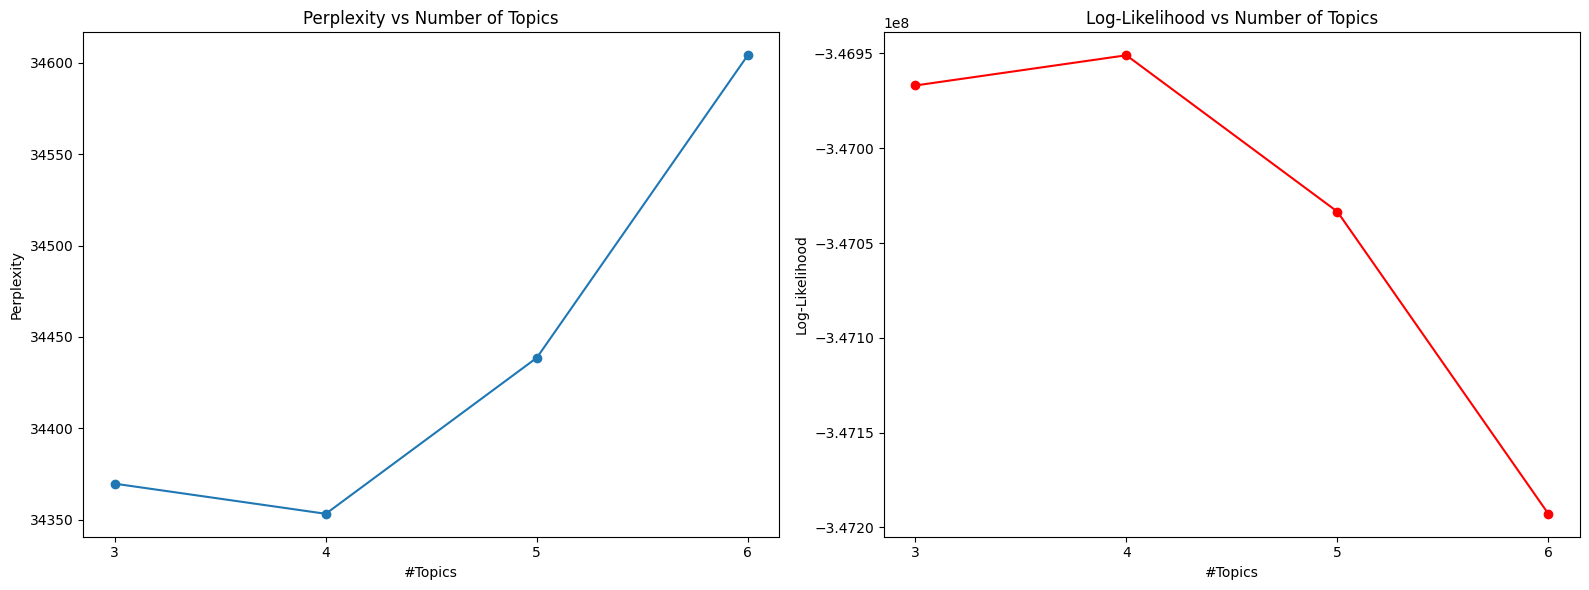

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(list(perplexities.keys()), list(perplexities.values()), marker="o")
axes[0].set_title("Perplexity vs Number of Topics")
axes[0].set_xlabel("#Topics")
axes[0].set_ylabel("Perplexity")
axes[1].plot(list(log_likelihoods.keys()), list(log_likelihoods.values()), color='red', marker="o")
axes[1].set_title("Log-Likelihood vs Number of Topics")
axes[1].set_xlabel("#Topics")
axes[1].set_ylabel("Log-Likelihood")
plt.tight_layout()
plt.show()

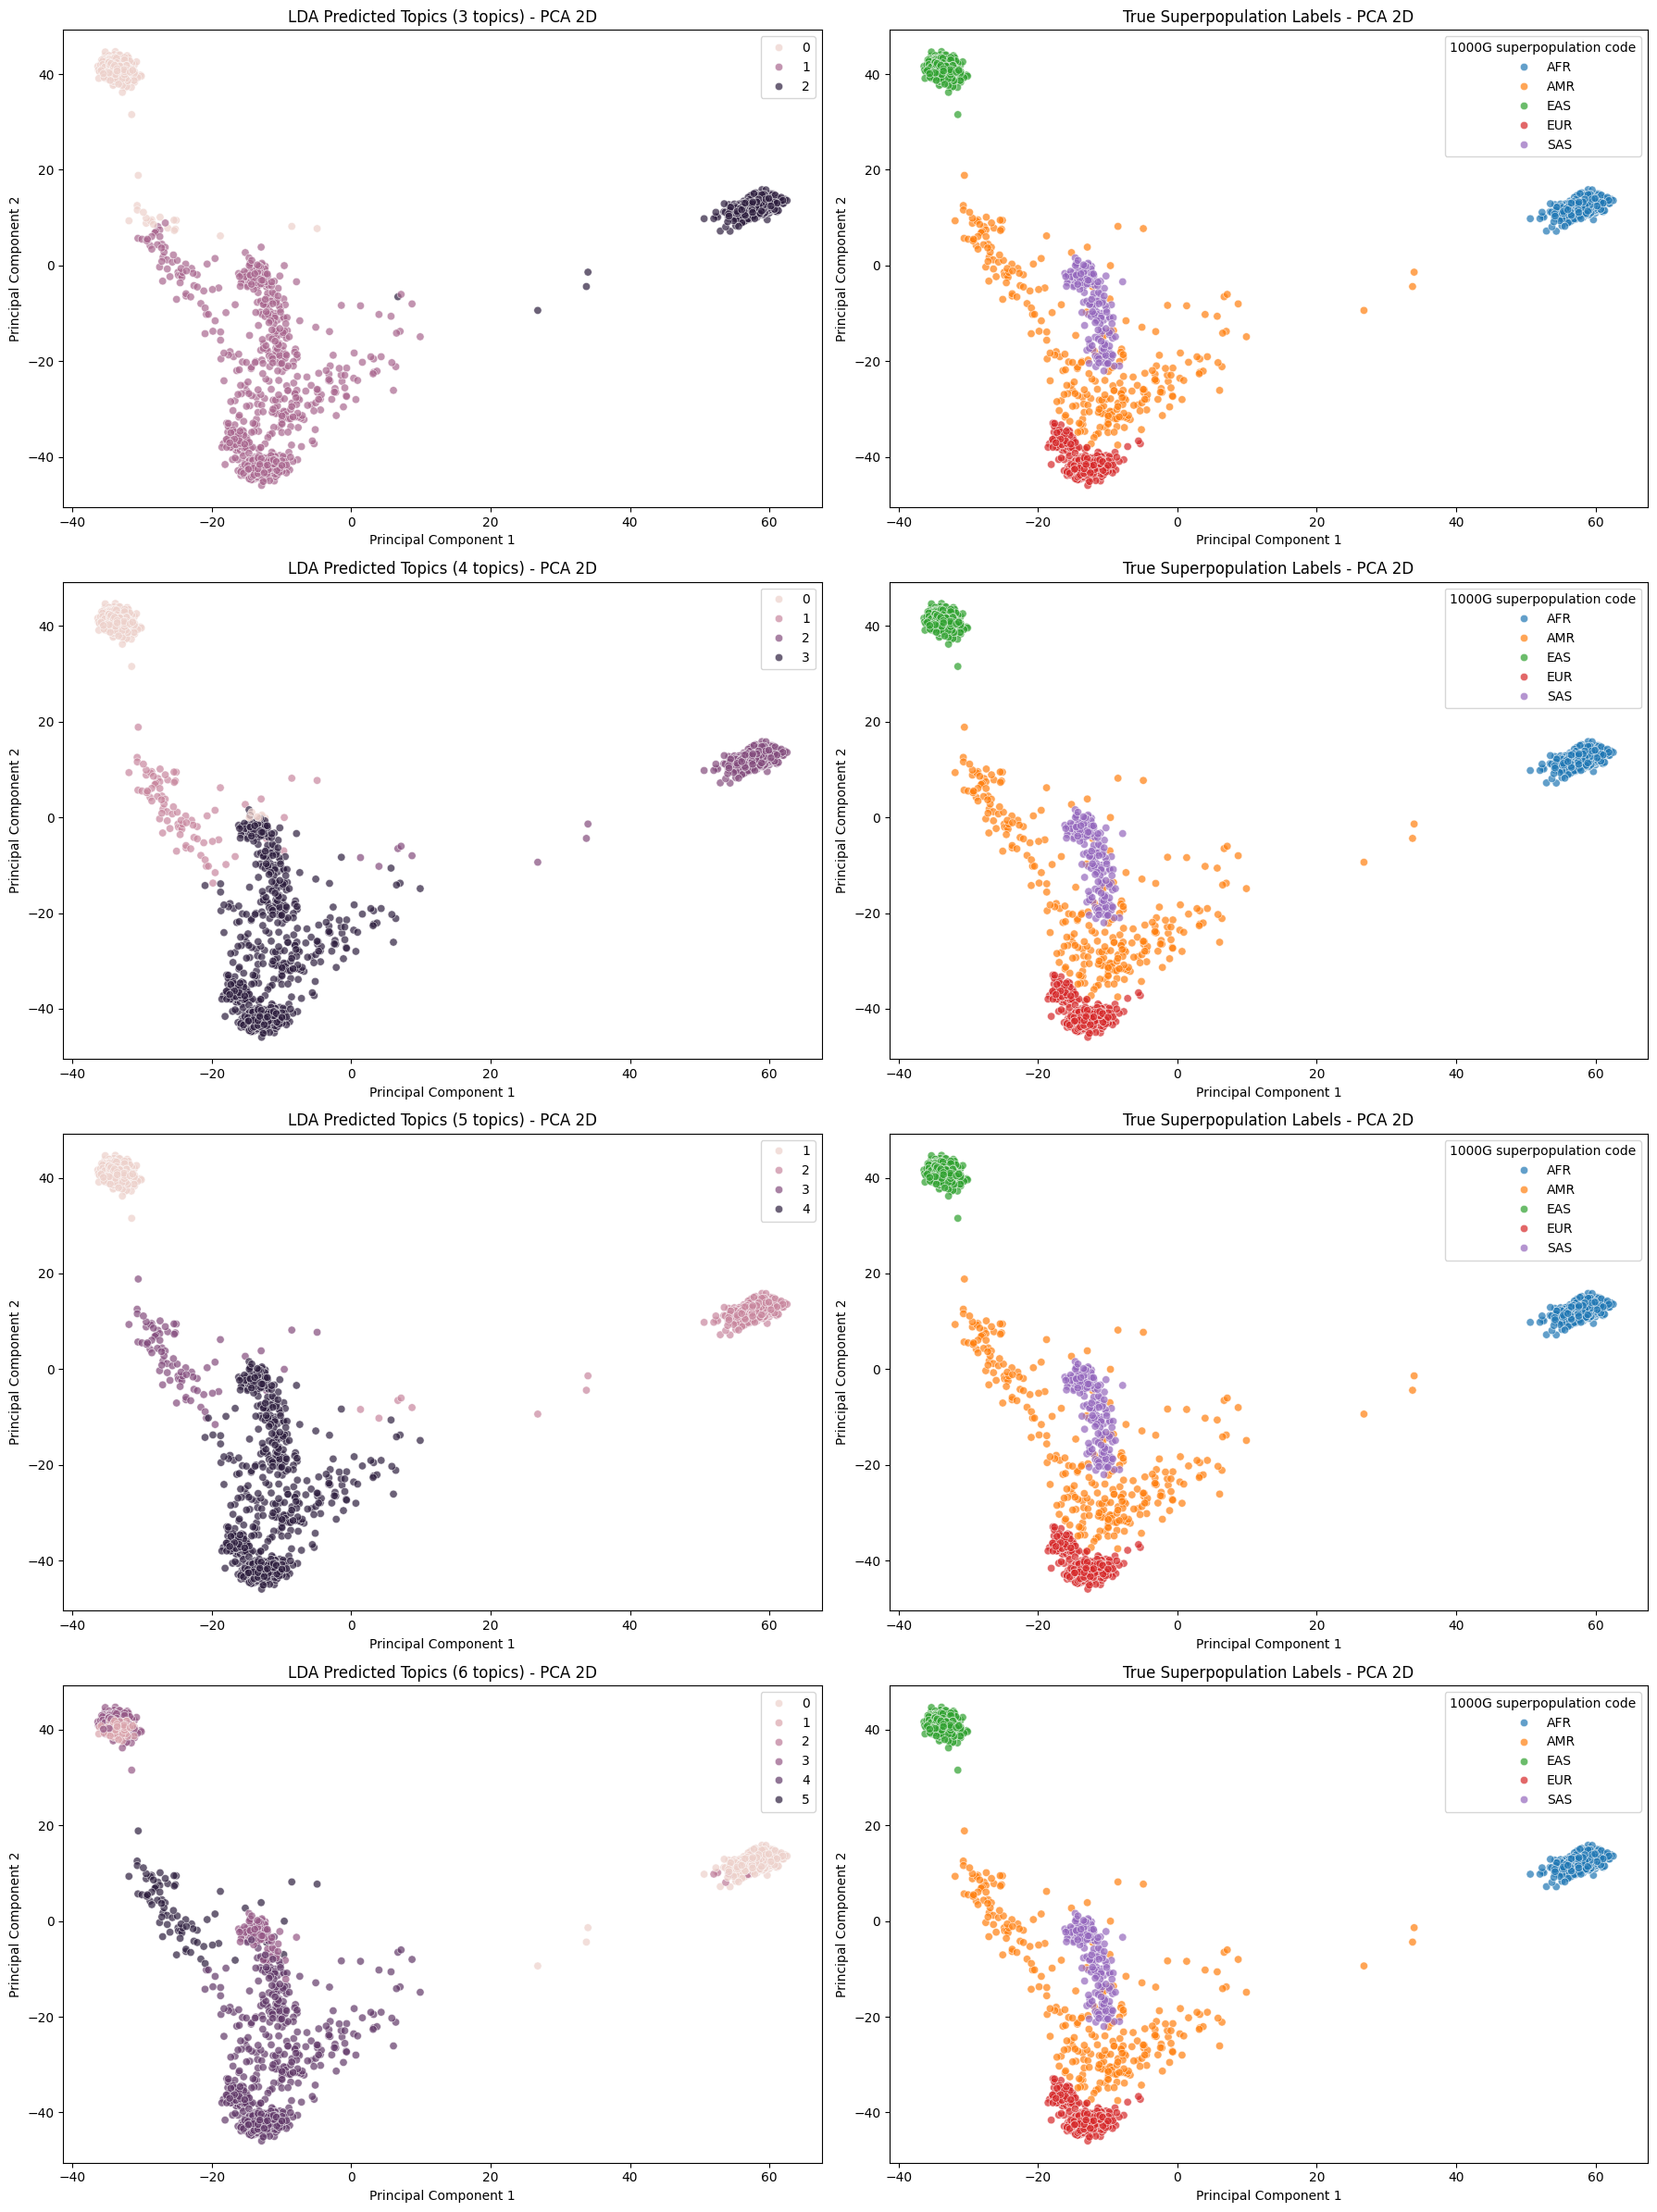

In [43]:
fig, axes = plt.subplots(len(predicted_topics), 2, figsize=(18, 6*len(predicted_topics)))
for i, (n_topics, labels) in enumerate(predicted_topics.items()):
    sns.scatterplot(x=X_pca_n[:, 0], y=X_pca_n[:, 1], hue=labels, alpha=0.7, ax=axes[i,0])
    axes[i,0].set_title(f"LDA Predicted Topics ({n_topics} topics) - PCA 2D")
    axes[i,0].set_xlabel("Principal Component 1")
    axes[i,0].set_ylabel("Principal Component 2")

    sns.scatterplot(x=X_pca_n[:, 0], y=X_pca_n[:, 1], hue=genotypes_annotation["1000G superpopulation code"], alpha=0.7, ax=axes[i,1])
    axes[i,1].set_title("True Superpopulation Labels - PCA 2D")
    axes[i,1].set_xlabel("Principal Component 1")
    axes[i,1].set_ylabel("Principal Component 2")
plt.tight_layout()
plt.show()

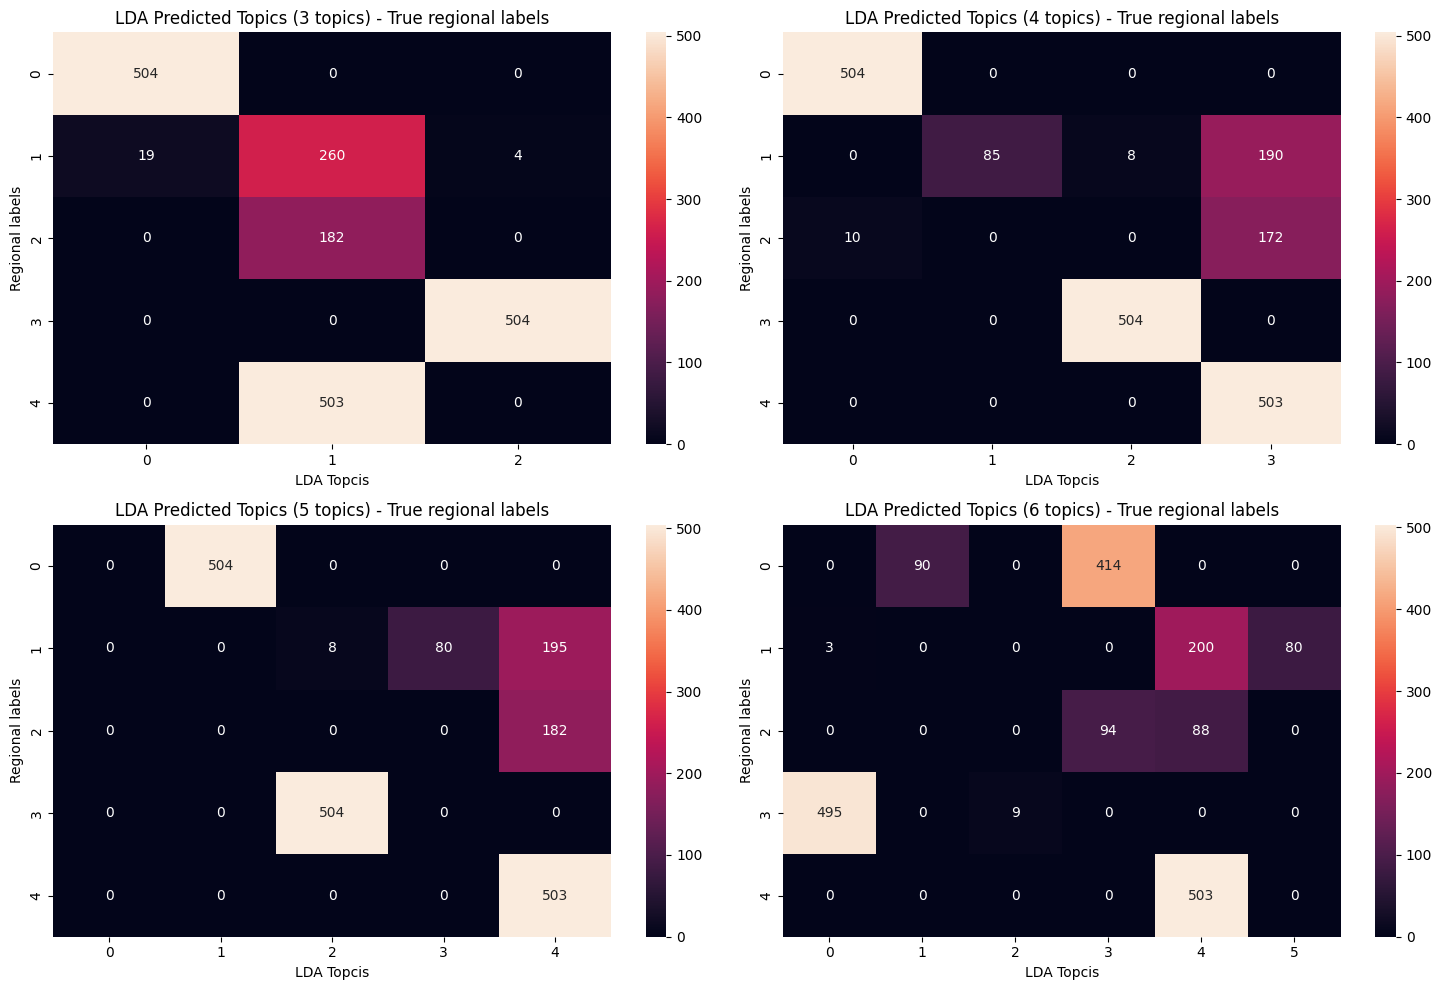

In [73]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))
for i, (n_topics, labels) in enumerate(predicted_topics.items()):
    n_topics = int(n_topics)
    real_label_set = set(genotypes_annotation["1000G superpopulation code"])
    topic_map = {v:i for i,v in enumerate(real_label_set)}
    conf_matrix = np.zeros((n_topics, len(topic_map)))
    for lda_label, real_label in zip(labels, genotypes_annotation["1000G superpopulation code"]):
        conf_matrix[lda_label, topic_map[real_label]] += 1
    conf_matrix = conf_matrix.T
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"LDA Predicted Topics ({n_topics} topics) - True regional labels")
    axes[i // 2, i % 2].set_xlabel("LDA Topcis")
    axes[i // 2, i % 2].set_ylabel("Regional labels")

plt.tight_layout()
plt.show()

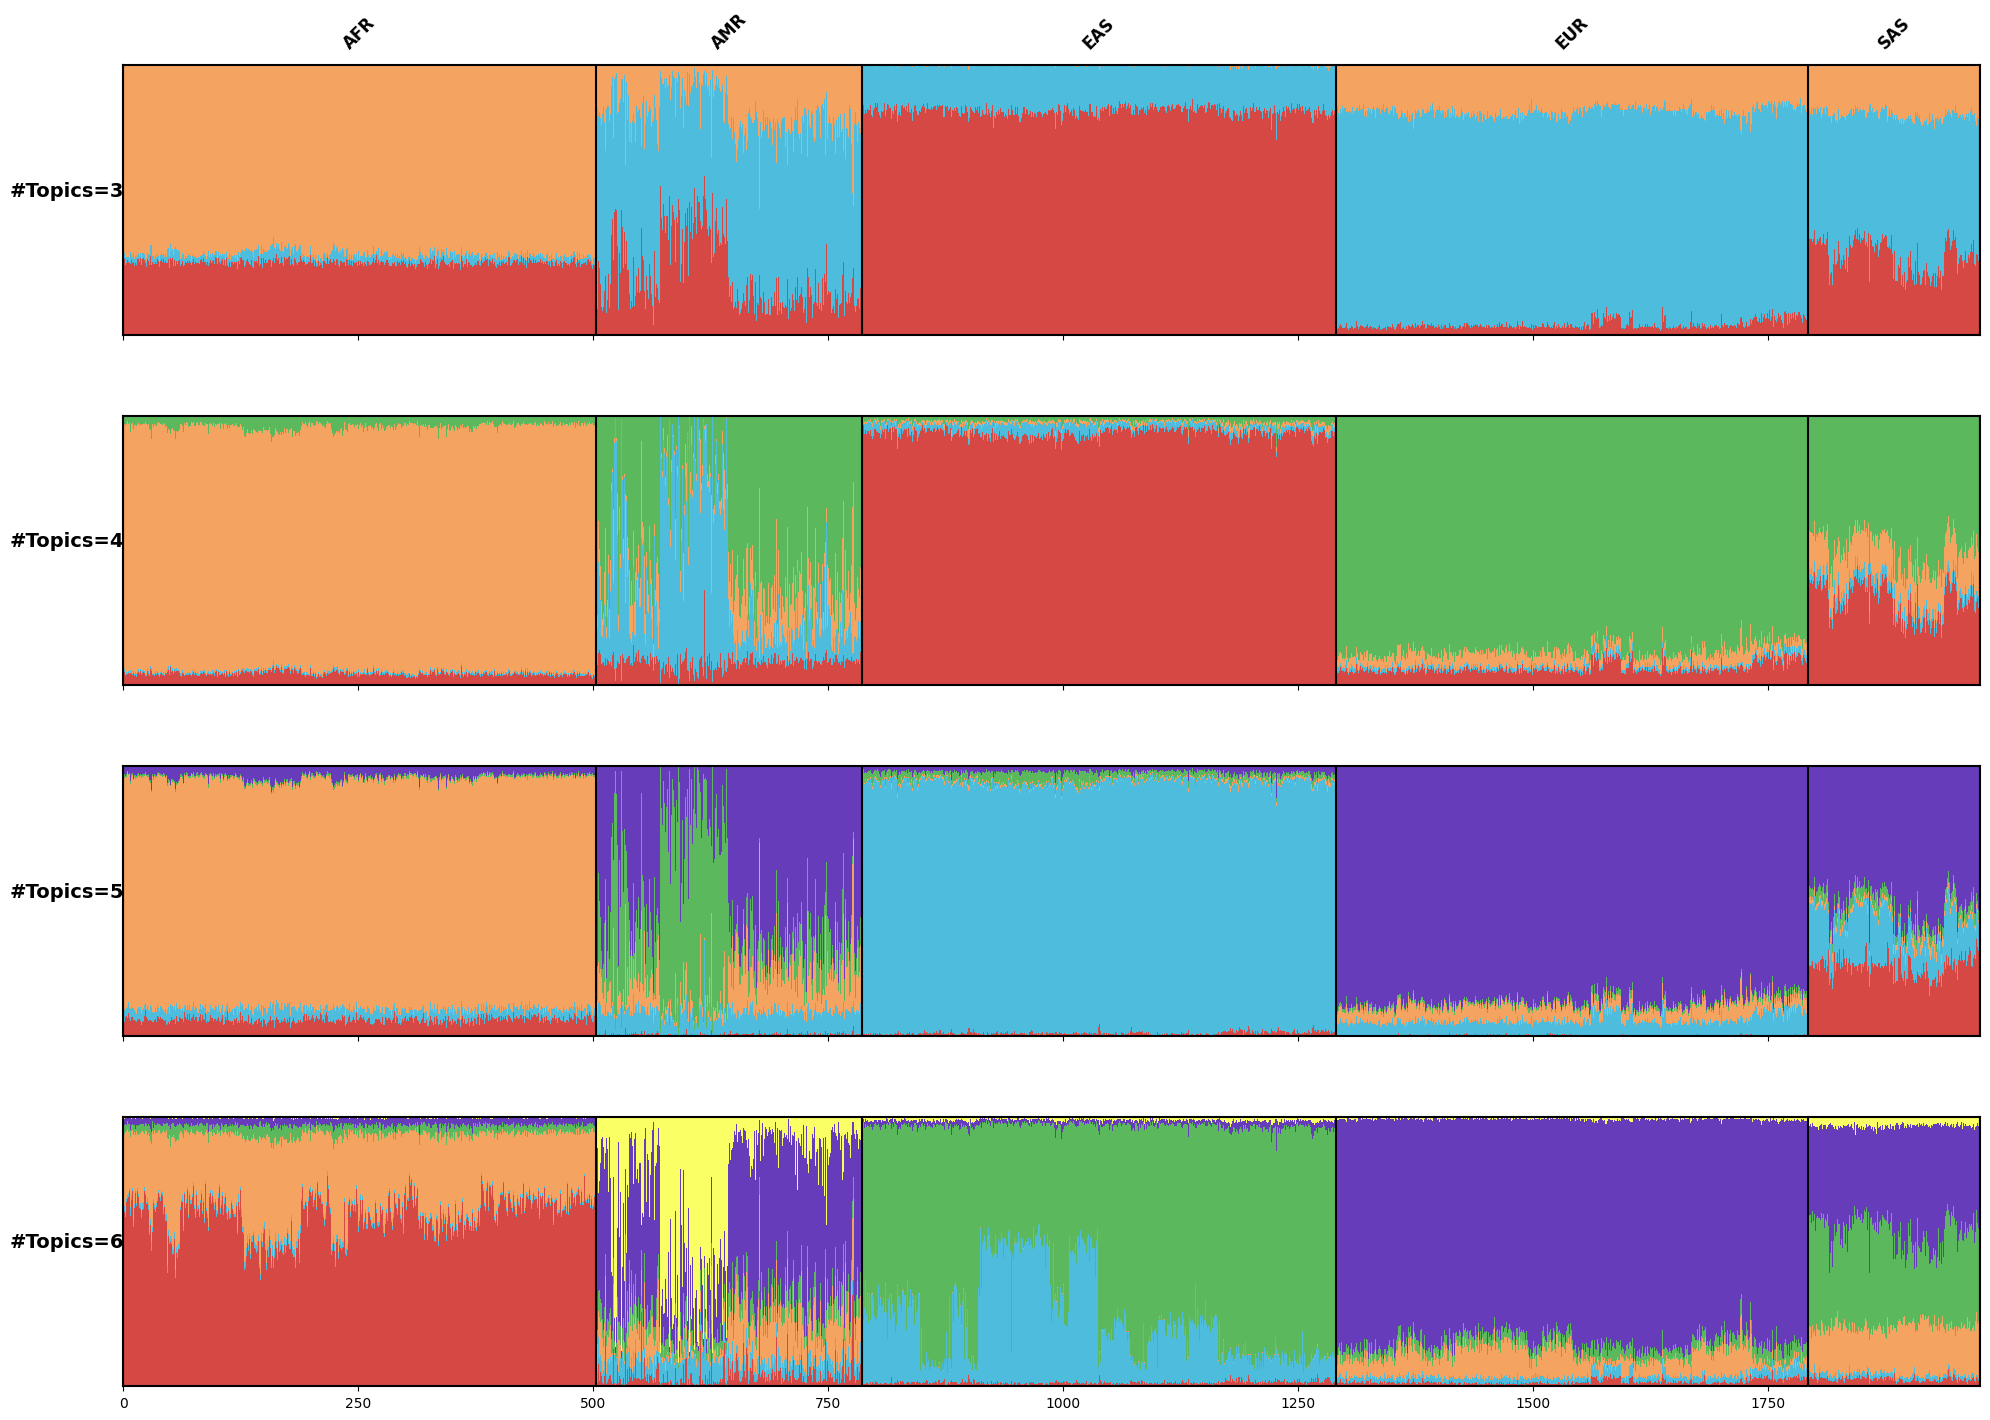

In [ ]:
population_labels = genotypes_annotation["1000G superpopulation code"].values
n_topic_options = sorted(topic_predictions.keys())

fig, axes = plt.subplots(len(n_topic_options), 1, figsize=(20, 4 * len(n_topic_options)), sharex=True)
if len(n_topic_options) == 1: axes = [axes]

colors = ["#d54843","#4dbcdd", '#f4a460', '#5cb85c', "#673cbb", "#faff66"]

for i, n_topics in enumerate(n_topic_options):
    data = np.array(topic_predictions[n_topics])
    df = pd.DataFrame(data)
    df['population'] = population_labels
    
    df_sorted = df.sort_values('population').reset_index(drop=True)
    sorted_pops = df_sorted['population']
    plot_data = df_sorted.drop(columns=['population']).values
    plot_data = plot_data / plot_data.sum(axis=1, keepdims=True)
    
    n_individuals, n_clusters = plot_data.shape
    bottom = np.zeros(n_individuals)
    
    for cluster_idx in range(n_clusters):
        axes[i].bar(range(n_individuals), plot_data[:, cluster_idx], 
                    bottom=bottom, width=1.0, 
                    color=colors[cluster_idx % len(colors)],
                    edgecolor='none')
        bottom += plot_data[:, cluster_idx]
    
    changes = np.where(sorted_pops.values[:-1] != sorted_pops.values[1:])[0]
    
    boundaries = np.concatenate([[-0.5], changes, [n_individuals - 0.5]])
    
    for b in boundaries:
        axes[i].axvline(b, color='black', linewidth=1.5)
    
    if i == 0:
        for start, end in zip(boundaries[:-1], boundaries[1:]):
            midpoint = (start + end) / 2
            label = sorted_pops.iloc[int(midpoint)]
            axes[i].text(midpoint, 1.05, label, ha='center', va='bottom', 
                         fontsize=12, fontweight='bold', rotation=45)

    axes[i].set_ylabel(f'#Topics={n_topics}', rotation=0, labelpad=40, fontweight='bold', fontsize=14)
    axes[i].set_ylim(0, 1)
    axes[i].set_xlim(-0.5, n_individuals - 0.5)
    axes[i].set_yticks([])
    
    for spine in axes[i].spines.values():
        spine.set_linewidth(1.5)
        spine.set_visible(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, top=0.85)
plt.show()

## TODO: Comments

In [82]:
genotypes_mixed  = pd.read_csv("./recoded_1000G_MXL.mat.xz", delimiter = ",", header = None)
genotypes_mixed_for_lda = reencode_matrix(genotypes_mixed)

/var/folders/_3/nm_bc9fx7t55l0fvfvxm8bww0000gn/T/ipykernel_85848/2596981318.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  genotype_matrix[genotype_matrix == 2] = 0.5


In [87]:
OUT_FILE_MEX = "lda_model_results_mex.json"

if not os.path.exists(OUT_FILE_MEX):
    model = LatentDirichletAllocation(
        n_components=6,
        max_iter=40,
        learning_method="batch",
        learning_offset=50.0,
        random_state=42,
        n_jobs=1,
        verbose=True
    )
    start_time = time()
    model.fit(genotypes_for_lda)
    end_time = time()

    topic_predictions_mex = model.transform(genotypes_mixed_for_lda).tolist()
    topic_predictions_other = model.transform(genotypes_for_lda).tolist()
    print(f"LDA model with 6 topics fitted in {end_time - start_time:.2f} seconds.")
    with open(OUT_FILE_MEX, "w") as f:
        json.dump({
            "mex_predictions": topic_predictions_mex,
            "other_predictions": topic_predictions_other,
        }, f)
else:
    print(f"Results file {OUT_FILE_MEX} already exists. Skipping LDA model fitting.")

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

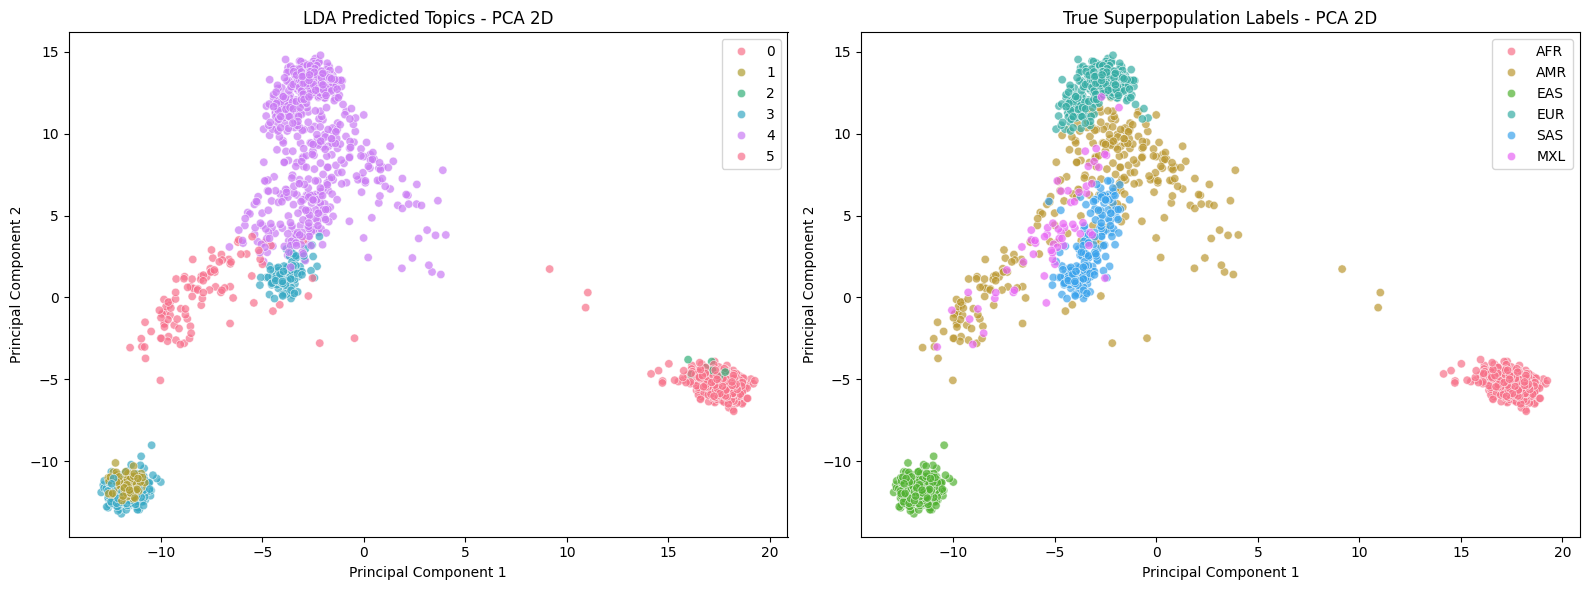

In [93]:
if os.path.exists(OUT_FILE_MEX):
    with open(OUT_FILE_MEX, "r") as f:
        obj = json.load(f)
        mex_ancestry_topics = obj["mex_predictions"]
        full_data_topics = obj["other_predictions"]

    full_data_pca = pca_n.fit_transform(genotypes_for_lda.toarray())
    mex_data_pca = pca_n.transform(genotypes_mixed_for_lda.toarray())
    
    full_pca = np.concatenate([full_data_pca, mex_data_pca], axis=0)
    full_topics = np.concatenate([full_data_topics, mex_ancestry_topics], axis=0)
    full_labels = np.concatenate([genotype_w_annotation["1000G superpopulation code"].values, ["MXL"] * len(mex_ancestry_topics)], axis=0)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(x=full_pca[:, 0], y=full_pca[:, 1], palette="husl", hue=full_topics.argmax(axis=1), alpha=0.7, ax=axes[0])
    axes[0].set_title("LDA Predicted Topics - PCA 2D")
    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")
    sns.scatterplot(x=full_pca[:, 0], y=full_pca[:, 1], palette="husl", hue=full_labels, alpha=0.7, ax=axes[1])
    axes[1].set_title("True Superpopulation Labels - PCA 2D")
    axes[1].set_xlabel("Principal Component 1")
    axes[1].set_ylabel("Principal Component 2")
    plt.tight_layout()
    plt.show()

    
else:    
    print(f"Results file {OUT_FILE} does not exist. Try to run the LDA model on mixed ancestry data first.")

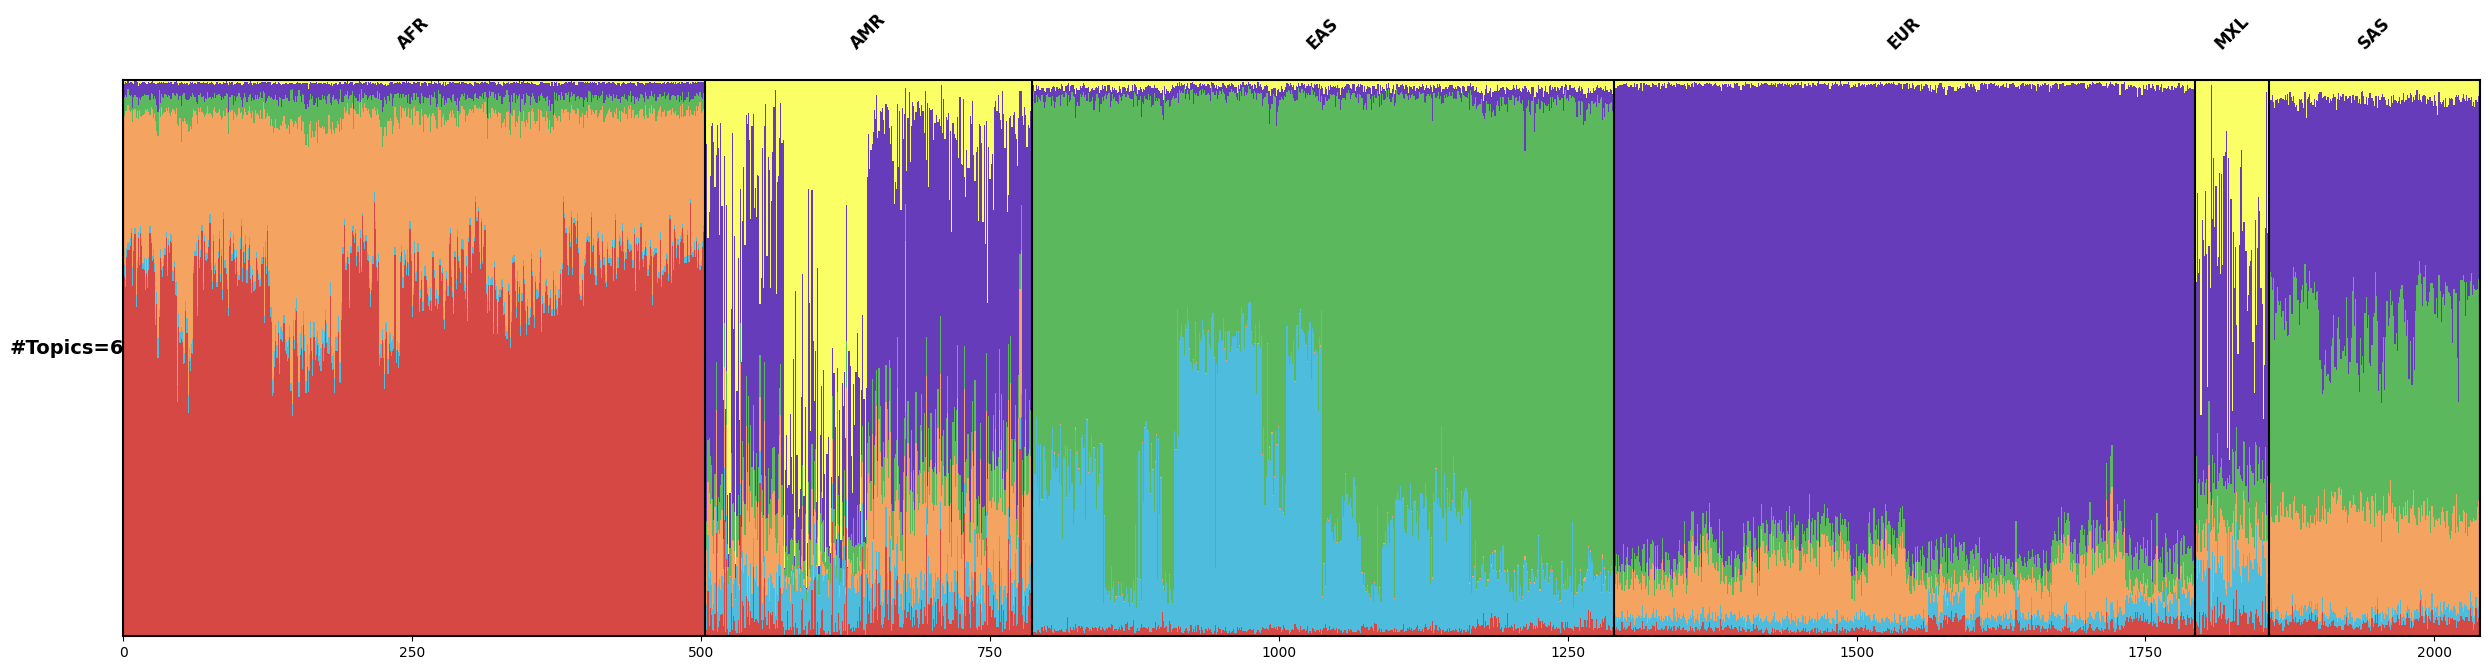

In [102]:
fig, axes = plt.subplots(figsize=(25, 7))

colors = ["#d54843","#4dbcdd", '#f4a460', '#5cb85c', "#673cbb", "#faff66"]

data = np.array(full_topics)
df = pd.DataFrame(data)
df['population'] = full_labels

df_sorted = df.sort_values('population').reset_index(drop=True)
sorted_pops = df_sorted['population']
plot_data = df_sorted.drop(columns=['population']).values
plot_data = plot_data / plot_data.sum(axis=1, keepdims=True)

n_individuals, n_clusters = plot_data.shape
bottom = np.zeros(n_individuals)

for cluster_idx in range(n_clusters):
    axes.bar(range(n_individuals), plot_data[:, cluster_idx], 
                bottom=bottom, width=1.0, 
                color=colors[cluster_idx % len(colors)],
                edgecolor='none')
    bottom += plot_data[:, cluster_idx]

changes = np.where(sorted_pops.values[:-1] != sorted_pops.values[1:])[0]

boundaries = np.concatenate([[-0.5], changes, [n_individuals - 0.5]])

for b in boundaries:
    axes.axvline(b, color='black', linewidth=1.5)

for start, end in zip(boundaries[:-1], boundaries[1:]):
    midpoint = (start + end) / 2
    label = sorted_pops.iloc[int(midpoint)]
    axes.text(midpoint, 1.05, label, ha='center', va='bottom', 
                 fontsize=12, fontweight='bold', rotation=45)
    
axes.set_ylabel(f'#Topics={6}', rotation=0, labelpad=40, fontweight='bold', fontsize=14)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, n_individuals - 0.5)
axes.set_yticks([])

for spine in axes.spines.values():
    spine.set_linewidth(1.5)
    spine.set_visible(True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, top=0.85)
plt.show()